# CPC Merged Analysis of Precipitation (CMAP)
<h3> 
Aaron Trefler <br/>
JPL <br/>
Created: 08/05/2016 <br/>
</h3>

# Setup

In [2]:
%load_ext autoreload
%autoreload 2

import datetime as dt
import flood_functions
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scipy.io as sio 
import seaborn as sns
import statsmodels.api as sm
import time

from IPython.display import display, HTML
from netCDF4 import Dataset
from netCDF4 import date2num
from scipy import stats

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
print 'Matplotlib Styles:', '\n'.join(plt.style.available)

Matplotlib Styles: seaborn-darkgrid
seaborn-notebook
classic
seaborn-ticks
grayscale
bmh
seaborn-talk
dark_background
ggplot
fivethirtyeight
seaborn-colorblind
seaborn-deep
seaborn-whitegrid
seaborn-bright
seaborn-poster
seaborn-muted
seaborn-paper
seaborn-white
seaborn-pastel
seaborn-dark
seaborn-dark-palette


In [4]:
%pylab inline
#%matplotlib

plt.style.use('ggplot')
sns.set(font_scale=1.5)
fig_large = (18,9.9)
fig_small = (9,4.45)

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [5]:
# define directories
dir_python_data = '../Data/'
dir_cmap = '../../Raw Data/CMAP Precipitation/'

# Load Data

## GRACE Times

In [6]:
f = open(dir_python_data + 'grace_time_datestr.p', 'rb')
grace_time_datestr = pickle.load(f)
f.close()

## Land Mask

In [7]:
# lowres land mask
f = open(dir_python_data + 'grace_land_mask_lowres.p', 'rb')
land_mask = pickle.load(f)
f.close()

## CMAP Precipitation

## Pentad

In [8]:
# extract pentad precip variables
cmapgrp = Dataset(dir_cmap + 'precip.pentad.mean.nc', 'r')
print "Pentad Precip NetCDF File Information\n", cmapgrp
precip_var = cmapgrp.variables['precip']
time_var  = cmapgrp.variables['time']

# convert varaiables to numpy arrays
print "Precipitation Information:\n", precip_var
precip = precip_var[:,:,:] # convert to numpy array
time = time_var[:] * 60 * 60 # convert to numpy array in seconds

cmapgrp.close()

Pentad Precip NetCDF File Information
<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: CPC Merged Analysis of Precipitation Pentad data (includes NCEP Reanalysis I)
    platform: Analyses
    documentation: http://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    Version: V1201
    source: ftp ftp.cpc.ncep.noaa.gov precip/cmap/pentad
    hisotry: Converted to chunked, deflated non-packed NetCDF4 Jul 2014
    history: Created by CAS 09/2012  using Version 1201update 8/2015
    version: V1506
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    dataset_title: CPC Merged Analysis of Precipitation
    dimensions(sizes): lon(144), lat(72), time(2658)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 precip(time,lat,lon)
    groups: 

Precipitation Information:
<type 'netCDF4._netCDF4.Variable'>
float32 precip(time, lat, lon)
    long_name: Avera

## Monthly

In [9]:
# extract monthly precip variables
cmapgrp = Dataset(dir_cmap + 'precip.mon.mean.nc', 'r')
print "Monthly Precip NetCDF File Information\n", cmapgrp
precip_monthly_var = cmapgrp.variables['precip']
time_monthly_var  = cmapgrp.variables['time']

# convert varaiables to numpy arrays
print "Precipitation Information:\n", precip_monthly_var
precip_monthly = precip_monthly_var[:,:,:] # convert to numpy array
time_monthly = time_monthly_var[:] * 60 * 60 # convert to numpy array in seconds

cmapgrp.close()

Monthly Precip NetCDF File Information
<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    Conventions: COARDS
    title: CPC Merged Analysis of Precipitation (includes NCEP Reanalysis)
    platform: Analyses
    source: ftp ftp.cpc.ncep.noaa.gov precip/cmap/monthly
    documentation: http://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    References: http://www.esrl.noaa.gov/psd/data/gridded/data.cmap.html
    dataset_title: CPC Merged Analysis of Precipitation
    version: V1607
    history: update 7/2016 V1607
    dimensions(sizes): lon(144), lat(72), time(450)
    variables(dimensions): float32 lat(lat), float32 lon(lon), float64 time(time), float32 precip(time,lat,lon)
    groups: 

Precipitation Information:
<type 'netCDF4._netCDF4.Variable'>
float32 precip(time, lat, lon)
    long_name: Average Monthly Rate of Precipitation
    valid_range: [  0.  70.]
    units: mm/day
    add_offset: 0.0
    scale_factor: 1.0
    missing_value:

# Wrangle CMAP Precipitation 

## Monthly

In [10]:
#  create human readable time series
#
#  The times are encoded as the number of hours (or days) since 1-1-1 00:00:0.0 
#  (or 1800-1-1 00:00:0.0)

# calculate time diff b/w precip and posix
posix_time_start = dt.datetime.strptime('1970 1 1', '%Y %m %d')
precip_time_start = dt.datetime.strptime('1800 1 1', '%Y %m %d')
time_diff = posix_time_start - precip_time_start
time_diff_days = time_diff.days

# calculate time since POSIX start in seconds
time_posix = time_monthly  - (time_diff_days * 24 * 60 * 60)

# convert to date object
time_monthly_date = [dt.date.fromtimestamp(time_posix[i].astype(int)) for i in range(len(time_monthly))]

# convert to YYY-MM-HH
time_monthly_str = [time_monthly_date[i].strftime("%Y-%m-%d") for i in range(len(time_monthly))]

# dispay first and last dates of time variable
print time_monthly_str[0]
print time_monthly_str[-1]

1978-12-31
2016-05-31


In [11]:
# subset precip data based on GRACE

# define grace start date
grace_start_date = dt.datetime.strptime(grace_time_datestr[0], '%d-%b-%Y').date()
print "grace start date:", grace_start_date

# calculate cmap index pre grace start date
for i in range(len(time_monthly_date)):
    if (time_monthly_date[i] > grace_start_date):
        cmap_subset_start_date = time_monthly_date[i-1]
        cmap_subset_start_idx = i-1
        break
print "cmap subset start date:", cmap_subset_start_date

# subset precip data
precip_monthly_subset = precip_monthly[cmap_subset_start_idx:-1,:,:]
time_date_monthly_subset = time_monthly_date[cmap_subset_start_idx:-1]
time_str_monthly_subset = time_monthly_str[cmap_subset_start_idx:-1]


grace start date: 2002-04-16
cmap subset start date: 2002-03-31


In [12]:
# re-arrange cmap-precip dimensions to match GRACE
precip_monthly_subset_alt = np.moveaxis(a=precip_monthly_subset, source=0, destination=-1)

In [13]:
# convert resolution of cmap-precip to match GRACE-highres (360, 720)
precip_monthly_subset_alt_highres = \
    flood_functions.brick_convert_highres(data_brick=precip_monthly_subset_alt, scale=5)


## Pentad

In [14]:
#  create human readable time series
#
#  The times are encoded as the number of hours (or days) since 1-1-1 00:00:0.0 
#  (or 1800-1-1 00:00:0.0)

# calculate time diff b/w precip and posix
posix_time_start = dt.datetime.strptime('1970 1 1', '%Y %m %d')
precip_time_start = dt.datetime.strptime('1800 1 1', '%Y %m %d')
time_diff = posix_time_start - precip_time_start
time_diff_days = time_diff.days

# calculate time since POSIX start in seconds
time_posix = time  - (time_diff_days * 24 * 60 * 60)

# convert to date object
time_date = [dt.date.fromtimestamp(time_posix[i].astype(int)) for i in range(len(time))]

# convert to YYY-MM-HH
time_str = [time_date[i].strftime("%Y-%m-%d") for i in range(len(time))]

# dispay first and last dates of time variable
print time_str[0]
print time_str[-1]

1978-12-31
2015-05-25


In [15]:
# subset precip data based on GRACE

# define grace start date
grace_start_date = dt.datetime.strptime(grace_time_datestr[0], '%d-%b-%Y').date()
print "grace start date:", grace_start_date

# calculate cmap index pre grace start date
for i in range(len(time_date)):
    if (time_date[i] > grace_start_date):
        cmap_subset_start_date = time_date[i-1]
        cmap_subset_start_idx = i-1
        break
print "cmap subset start date:", cmap_subset_start_date

# subset precip data
precip_subset = precip[cmap_subset_start_idx:-1,:,:]
time_date_subset = time_date[cmap_subset_start_idx:-1]
time_str_subset = time_str[cmap_subset_start_idx:-1]


grace start date: 2002-04-16
cmap subset start date: 2002-04-15


In [16]:
# re-arrange cmap-precip dimensions to match GRACE
precip_subset_alt = np.moveaxis(a=precip_subset, source=0, destination=-1)

In [17]:
# convert resolution of cmap-precip to match GRACE-highres (360, 720)
precip_subset_alt_highres = \
    flood_functions.brick_convert_highres(data_brick=precip_subset_alt, scale=5)


# Create CMAP Precipitation Features

## Monthly

In [18]:
# monthly

cmap_monthly_precip_3D = precip_monthly_subset_alt_highres
tp = cmap_monthly_precip_3D.shape[2]

# normalize
cmap_monthly_precip_mean = np.mean(cmap_monthly_precip_3D, axis=2) 
cmap_monthly_precip_mean_3D = np.tile(cmap_monthly_precip_mean[:,:,np.newaxis], (1,1,tp))
cmap_monthly_precip_std = np.std(cmap_monthly_precip_3D, axis=2)
cmap_monthly_precip_std_3D = np.tile(cmap_monthly_precip_std[:,:,np.newaxis], (1,1,tp))

cmap_monthly_precip_norm_3D = (cmap_monthly_precip_3D - cmap_monthly_precip_mean_3D) / cmap_monthly_precip_std_3D

## Pentad

In [19]:
# pentad

cmap_precip_3D = precip_subset_alt_highres
tp = cmap_precip_3D.shape[2]

# normalize
cmap_precip_mean = np.mean(cmap_precip_3D, axis=2) 
cmap_precip_mean_3D = np.tile(cmap_precip_mean[:,:,np.newaxis], (1,1,tp))
cmap_precip_std = np.std(cmap_precip_3D, axis=2)
cmap_precip_std_3D = np.tile(cmap_precip_std[:,:,np.newaxis], (1,1,tp))

cmap_precip_norm_3D = (cmap_precip_3D - cmap_precip_mean_3D) / cmap_precip_std_3D

# Display Data

## Monthly

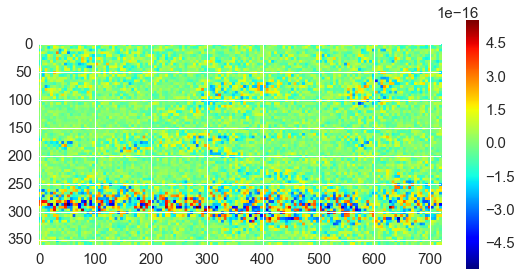

In [20]:
# calculate mean over timepoints, values should be all zeros
figure(figsize=fig_small)
plt.imshow(np.mean(cmap_monthly_precip_norm_3D, axis=2), cmap='jet')
plt.colorbar()
plt.show()

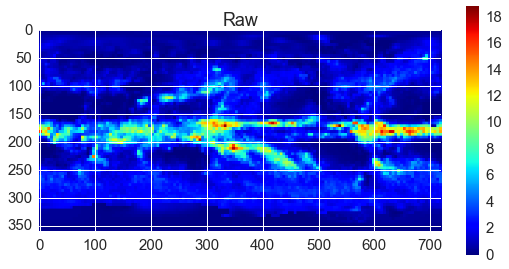

In [21]:
# plot raw precip data
figure(figsize=fig_small)
plt.imshow(cmap_monthly_precip_3D[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Raw')
plt.show()

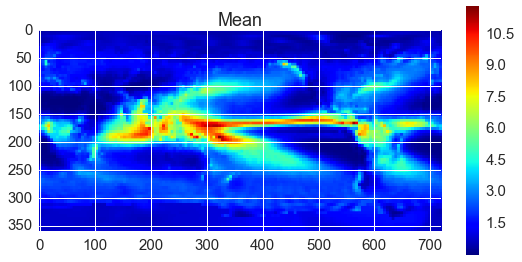

In [22]:
# plot mean precip data
figure(figsize=fig_small)
plt.imshow(cmap_monthly_precip_mean_3D[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Mean')
plt.show()

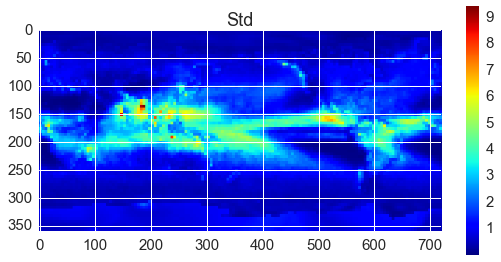

In [23]:
# plot std precip data
figure(figsize=fig_small)
plt.imshow(cmap_monthly_precip_std_3D[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Std')
plt.show()

In [24]:
data = np.mean(cmap_monthly_precip_norm_3D, axis=0)
data = np.mean(data, axis=0)

print "Precip Norm Max Value Index:", argmax(data)
print "Precip Norm Max Value:", max(data)
print
print "Precip Norm Min Value Index:", argmin(data)
print "Precip Norm Min Value:", min(data)

Precip Norm Max Value Index: 134
Precip Norm Max Value: 0.344509788751

Precip Norm Min Value Index: 44
Precip Norm Min Value: -0.27991885882


-0.0277585362012


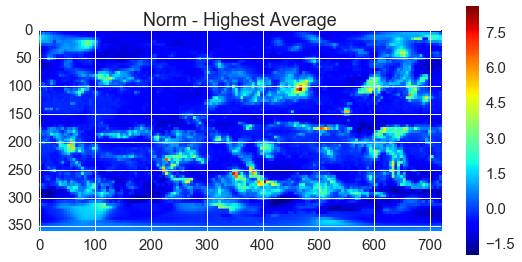

In [25]:
# plot normed precip with highres average
idx = 134
print np.mean(cmap_precip_norm_3D[:,:,idx])

figure(figsize=fig_small)
plt.imshow(cmap_precip_norm_3D[:,:,idx], cmap='jet')
plt.colorbar()
plt.title('Norm - Highest Average')
plt.show()

-0.27991885882


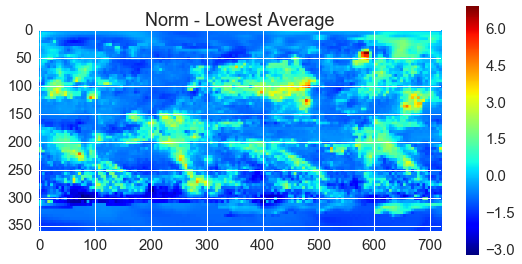

In [26]:
# plot normed precip with lowest average
idx = 44
print np.mean(cmap_monthly_precip_norm_3D[:,:,idx])

figure(figsize=fig_small)

plt.imshow(cmap_monthly_precip_norm_3D[:,:,idx], cmap='jet')
plt.colorbar()
plt.title('Norm - Lowest Average')
plt.show()

### Pentad

In [27]:
data = np.mean(cmap_precip_norm_3D, axis=0)
data = np.mean(data, axis=0)

print "Precip Norm Max Value Index:", argmax(data)
print "Precip Norm Max Value:", max(data)
print
print "Precip Norm Min Value Index:", argmin(data)
print "Precip Norm Min Value:", min(data)

Precip Norm Max Value Index: 303
Precip Norm Max Value: 0.893643878646

Precip Norm Min Value Index: 269
Precip Norm Min Value: -0.244656109917


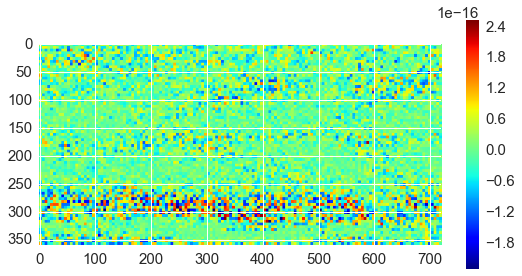

In [28]:
# calculate mean over timepoints, values should be all zeros
figure(figsize=fig_small)
plt.imshow(np.mean(cmap_precip_norm_3D, axis=2), cmap='jet')
plt.colorbar()
plt.show()

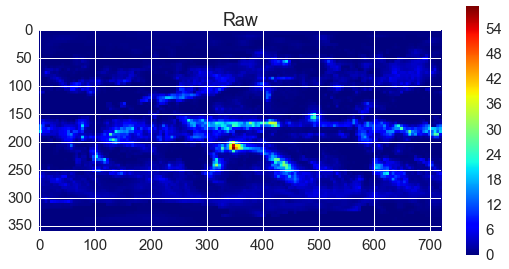

In [29]:
# plot raw precip data
figure(figsize=fig_small)
plt.imshow(cmap_precip_3D[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Raw')
plt.show()

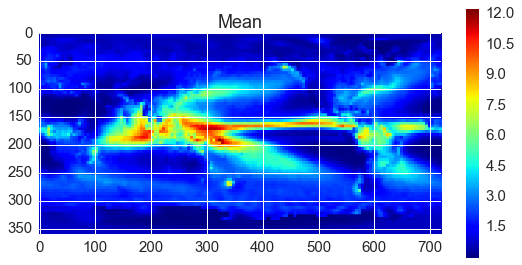

In [30]:
# plot mean precip data
figure(figsize=fig_small)
plt.imshow(cmap_precip_mean_3D[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Mean')
plt.show()

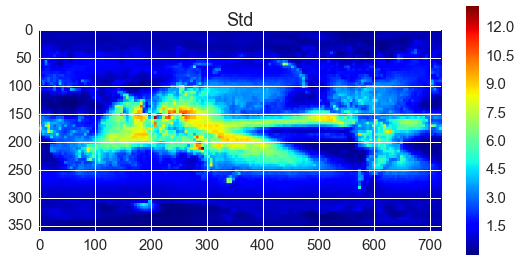

In [31]:
# plot std precip data
figure(figsize=fig_small)
plt.imshow(cmap_precip_std_3D[:,:,0], cmap='jet')
plt.colorbar()
plt.title('Std')
plt.show()

-0.244656109917


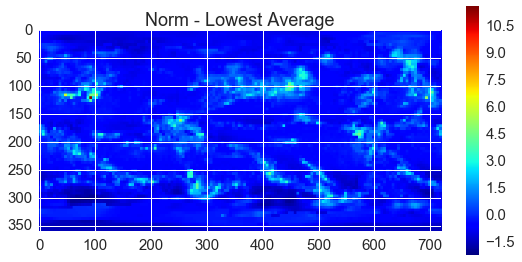

In [32]:
# plot normed precip with lowest average
idx = 269
print np.mean(cmap_precip_norm_3D[:,:,idx])

figure(figsize=fig_small)

plt.imshow(cmap_precip_norm_3D[:,:,idx], cmap='jet')
plt.colorbar()
plt.title('Norm - Lowest Average')
plt.show()

0.893643878646


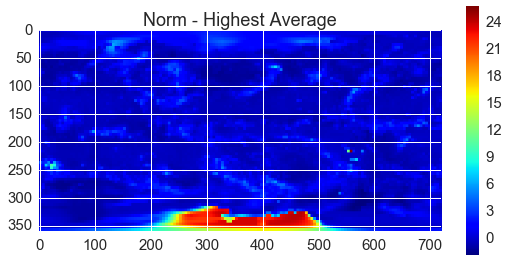

In [33]:
# plot normed precip with highres average
idx = 303
print np.mean(cmap_precip_norm_3D[:,:,idx])

figure(figsize=fig_small)
plt.imshow(cmap_precip_norm_3D[:,:,idx], cmap='jet')
plt.colorbar()
plt.title('Norm - Highest Average')
plt.show()

# Save Data

## Monthly

### CMAP Precipitation High Resolution Brick

In [42]:
# define dictionary
cmap_monthly_precip_highres_dict = {'cmap_precip_monthly': cmap_monthly_precip_3D,
                                    'cmap_precip_monthly_norm': cmap_monthly_precip_norm_3D}
# pickle
f = open(dir_python_data + 'cmap_monthly_precip_highres_dict.p', 'wb') 
pickle.dump(cmap_monthly_precip_highres_dict,f, -1)
f.close()

### CMAP Time Series

In [43]:
# define dictionary
cmap_monthly_precip_time_dict = {'cmap_precip_time_date_monthly': time_date_monthly_subset,
                                 'cmap_precip_time_str_monthly': time_str_monthly_subset}

# pickle
f = open(dir_python_data + 'cmap_monthly_precip_time_dict.p', 'wb') 
pickle.dump(cmap_monthly_precip_time_dict,f, -1)
f.close()

## Pentad

### CMAP Precipitation High Resolution Brick

In [44]:
# define dictionary
cmap_pentad_precip_highres_dict = {'cmap_precip_penta': cmap_precip_3D,
                                   'cmap_precip_penta_norm': cmap_precip_norm_3D}
# pickle
f = open(dir_python_data + 'cmap_pentad_precip_highres_dict.p', 'wb') 
pickle.dump(cmap_pentad_precip_highres_dict,f, -1)
f.close()

### CMAP Time Series

In [45]:
# define dictionary
cmap_pentad_precip_time_dict = {'cmap_precip_time_date_pentad': time_date_subset,
                                'cmap_precip_time_str_pentad': time_str_subset}

# pickle
f = open(dir_python_data + 'cmap_pentad_precip_time_dict.p', 'wb') 
pickle.dump(cmap_pentad_precip_time_dict,f, -1)
f.close()